In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import t
from copulas.univariate import GaussianKDE
from copulas.bivariate import Clayton, Gumbel
from copulas.multivariate import VineCopula, GaussianMultivariate
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf

# Set random seed
np.random.seed(1)

# function to download stock data
def download_stock_data(ticket_list, start_date, end_date):
    data = yf.download(ticket_list, start=start_date, end=end_date, interval='1mo')
    data = data['Adj Close']
    data.reset_index(inplace=True)
    return data


# Load data
portfolio = download_stock_data('AAPL MSFT AMZN GOOGL META TSLA BRK-B JPM JNJ V UNH', '2010-01-01', '2025-01-01')
portfolio = portfolio[(portfolio['Date'] >= '2020-01-01') & (portfolio['Date'] <= '2025-01-01')].iloc[:]
portfolio['Date'] = pd.to_datetime(portfolio['Date'])
portfolio.set_index('Date', inplace=True)
print(portfolio.shape)

# Convert to log returns
portfolio_logreturns = np.log(portfolio).diff().dropna() * 100


# Initialize portfolio specifications
n_assets = portfolio_logreturns.shape[1]
w_GMV = np.zeros((len(portfolio_logreturns) - 50, n_assets))
w_Gaussian_CVaR = np.zeros_like(w_GMV)
w_tCopula_CVaR = np.zeros_like(w_GMV)
w_Vine_CVaR = np.zeros_like(w_GMV)

# GARCH model fitting
def fit_garch(series):
    model = arch_model(series, vol='Garch', p=1, q=1, dist='t')
    fitted_model = model.fit(disp='off')
    return fitted_model

def predict_garch(fitted_model):
    forecast = fitted_model.forecast(horizon=1)
    return forecast.variance.values[-1, 0], fitted_model.resid / np.sqrt(fitted_model.conditional_volatility)

# Portfolio optimization
def min_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def portfolio_cvar(weights, returns, alpha=0.95):
    portfolio_returns = returns @ weights
    sorted_returns = np.sort(portfolio_returns)
    index = int(alpha * len(sorted_returns))
    return -np.mean(sorted_returns[:index])

def optimize_portfolio(cov_matrix, returns=None, alpha=0.95, method="variance"):
    n_assets = cov_matrix.shape[0]
    bounds = [(0, 1) for _ in range(n_assets)]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    if method == "variance":
        result = minimize(min_variance, x0=np.ones(n_assets) / n_assets, args=(cov_matrix,), 
                          bounds=bounds, constraints=constraints)
    elif method == "cvar" and returns is not None:
        result = minimize(portfolio_cvar, x0=np.ones(n_assets) / n_assets, args=(returns, alpha),
                          bounds=bounds, constraints=constraints)
    else:
        raise ValueError("Invalid optimization method.")
    return result.x

# Backtesting loop
for i in range(50, len(portfolio_logreturns)):
    window_data = portfolio_logreturns.iloc[i-50:i]

    # GARCH modeling
    print(f'Fitting GARCH model for window {i}')
    garch_fits = [fit_garch(window_data[col]) for col in window_data.columns]
    garch_predictions = [predict_garch(fit) for fit in garch_fits]
    print("GARCH model fitted\n\n")
    
    # Copula fitting (Gaussian, t, Vine)
    print(f'Fitting copula model for window {i}')
    residuals = np.array([pred[1] for pred in garch_predictions]).T
    residuals_df = pd.DataFrame(residuals, columns=window_data.columns)
    # gaussian_copula = GaussianMultivariate(dim=len(window_data.columns))
    # gaussian_copula.fit(residuals)
    # t_copula = StudentT()
    # t_copula.fit(residuals)
    vine_copula = VineCopula("center")
    vine_copula.fit(residuals_df)
    print("Copula model fitted\n\n")

    # Simulations
    print(f'Simulating copula model for window {i}')
    # simulated_gaussian = gaussian_copula.sample(1000)
    # simulated_t = t_copula.sample(1000)
    simulated_vine = vine_copula.sample(100)
    print("Copula model simulated\n\n")
    
    print(simulated_vine)

    # Portfolio optimization
    cov_matrix = window_data.cov()
    w_GMV[i - 50] = optimize_portfolio(cov_matrix, method="variance")
    # w_Gaussian_CVaR[i - 50] = optimize_portfolio(cov_matrix, simulated_gaussian, method="cvar")
    # w_tCopula_CVaR[i - 50] = optimize_portfolio(cov_matrix, simulated_t, method="cvar")
    w_Vine_CVaR[i - 50] = optimize_portfolio(cov_matrix, simulated_vine, method="cvar")

# Compute portfolio values
portfolio_values = {}
portfolio_values['GMV'] = (w_GMV @ portfolio_logreturns.T).sum(axis=1).cumsum()
# portfolio_values['Gaussian_CVaR'] = (w_Gaussian_CVaR @ portfolio_logreturns.T).sum(axis=1).cumsum()
# portfolio_values['tCopula_CVaR'] = (w_tCopula_CVaR @ portfolio_logreturns.T).sum(axis=1).cumsum()
portfolio_values['Vine_CVaR'] = (w_Vine_CVaR @ portfolio_logreturns.T).sum(axis=1).cumsum()

# Plot results
plt.figure(figsize=(10, 6))
for label, values in portfolio_values.items():
    plt.plot(values, label=label)
plt.xlabel('Time')
plt.ylabel('Portfolio Value (Index)')
plt.title('Portfolio Wealth Trajectory')
plt.legend()
plt.show()

In [ ]:
print(portfolio_values)

Adding MSFT to the data source
Getting data for MSFT
Adding MMM to the data source
Getting data for MMM
Adding AXP to the data source
Getting data for AXP
Adding AMGN to the data source
Getting data for AMGN
Adding AAPL to the data source
Getting data for AAPL
Adding CSCO to the data source
Getting data for CSCO
Adding IBM to the data source
Getting data for IBM
Adding NVDA to the data source
Getting data for NVDA
Adding TSLA to the data source
Getting data for TSLA
Adding AMZN to the data source
Getting data for AMZN
Adding MRK to the data source
Getting data for MRK


e:\Projects\quant\portfolio-optimization-tool-and-backtest-framework\src\backtest\backtest.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.VaR_value = VaR_value[VaR_value.index >= allocated_weights.index[0]].ffill()
e:\Projects\quant\portfolio-optimization-tool-and-backtest-framework\src\backtest\backtest.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.CVaR_value = CVaR_value[CVaR_value.index >= allocated_weights.index[0]].ffill()
e:\Projects\quant\portfolio-optimization-tool-and-backtest-framework\src\backtest\backtest.py:102: Future

Adding ^GSPC to the data source
Getting data for ^GSPC
{'Total Return': 4.149301143100729, 'Mean Daily Return': 0.0019273513186965935, 'Std Dev of Daily Return': 0.029355494314099236, 'Sharpe Ratio': 0.06565555660804868, 'Max Drawdown': -0.4831256944598833, 'Calmar Ratio': 8.58845056407007, 'Alpha': 0.001615675328664652, 'Beta': 1.2615950130450693}


C:\Users\D3VAR5H\AppData\Roaming\Python\Python39\site-packages\copulas\multivariate\vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
C:\Users\D3VAR5H\AppData\Roaming\Python\Python39\site-packages\copulas\multivariate\vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
C:\Users\D3VAR5H\AppData\Roaming\Python\Python39\site-packages\copulas\multivariate\vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
C:\Users\D3VAR5H\AppData\Roaming\Python\Python39\site-packages\copulas\multivariate\vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
C:\Users\D3VAR5H\AppData\Roaming\Python\Python39\site-packages\copulas\multivariate\vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and m

Adding ^GSPC to the data source
Getting data for ^GSPC
{'Total Return': 0.8959006321411425, 'Mean Daily Return': 0.001006491889731345, 'Std Dev of Daily Return': 0.02909652949476025, 'Sharpe Ratio': 0.03459147558861258, 'Max Drawdown': -0.6512989825387555, 'Calmar Ratio': 1.375559698633234, 'Alpha': 0.0006781642621156601, 'Beta': 1.3289971344998814}


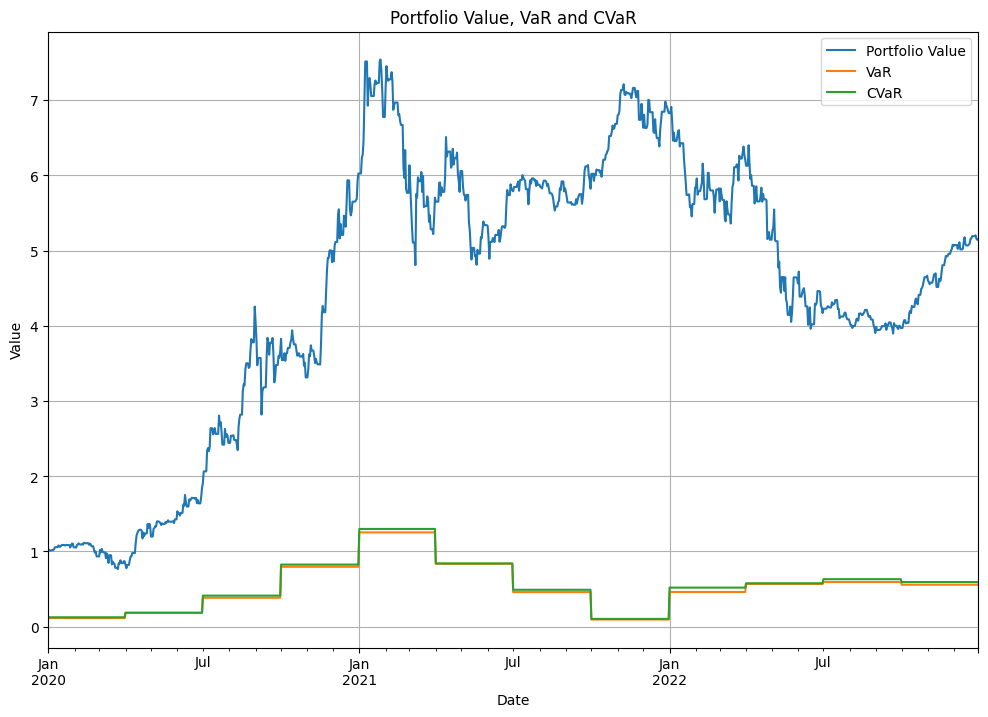

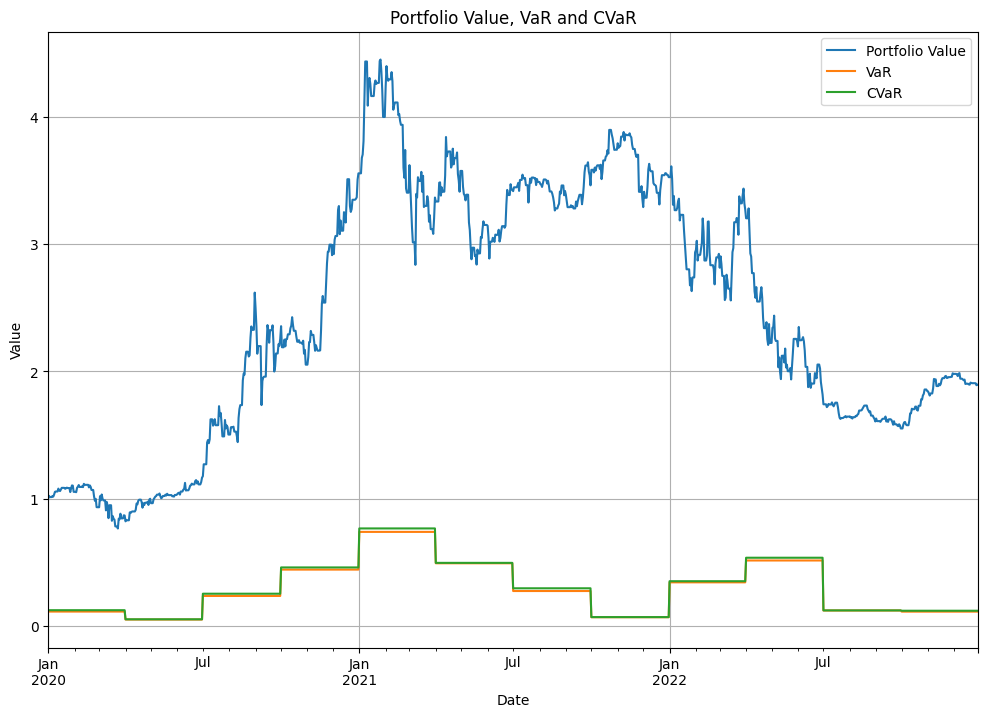

In [3]:
import datetime
from pprint import pprint
from src.datasource.yahoodata import YahooDataSource
from src.algorithms.strategy import MeanSemidevOpt
from src.backtest.backtest import BackTest

tickers = ['MSFT','MMM', 'AXP', 'AMGN', 'AAPL', 'CSCO','IBM','NVDA','TSLA','AMZN','MRK']
#tickers = ["RELIANCE.NS","MRF.NS","ICICIBANK.NS","INFY.NS","HINDUNILVR.NS","BHARTIARTL.NS","KOTAKBANK.NS","LT.NS","TCS.NS","BHARTIARTL.NS","TECHM.NS","NTPC.NS"]

column_name = 'Close'
interval = '1d'

start_date = datetime.datetime(2019,1,1)
end_date = datetime.datetime(2023,1,1)

# test data fetching
main_data = YahooDataSource(tickers,start_date,end_date,columns=[column_name],interval=interval)
data = main_data.get_data()
main_data.get_data_by_frequency(start_date,end_date,'1d').ffill()

# test strategy
meanSemidevOpt = MeanSemidevOpt(0.7)
meanSemidevOpt_bt = BackTest(main_data, meanSemidevOpt)

# with past data
meanSemidevOpt_bt.backtest(start_date, end_date, 12,3, '1MS')
meanSemidevOpt_bt.plot_portfolio_returns()
mean_semi_summary = meanSemidevOpt_bt.get_summary()
print(mean_semi_summary)

# with generated data
meanSemidevOpt_bt.backtest(start_date, end_date, 12,3, '1MS', use_generated_data=True)
meanSemidevOpt_bt.plot_portfolio_returns()
mean_semi_summary = meanSemidevOpt_bt.get_summary()
print(mean_semi_summary)

In [3]:
import pandas as pd
past_data = {'Total Return': 4.1492991901080885, 'Mean Daily Return': 0.0019273510173856917, 'Std Dev of Daily Return': 0.029355495843960952, 'Sharpe Ratio': 0.0656555429222017, 'Max Drawdown': -0.4831256248395041, 'Calmar Ratio': 8.588447759289313, 'Alpha': 0.0016156749642408448, 'Beta': 1.261595268512057}
gen_data_200 = {'Total Return': 3.6835497369912726, 'Mean Daily Return': 0.0018577372907579853, 'Std Dev of Daily Return': 0.029963594360437117, 'Sharpe Ratio': 0.06199981445520023, 'Max Drawdown': -0.4843803259345241, 'Calmar Ratio': 7.604664227194881, 'Alpha': 0.0015417272298976785, 'Beta': 1.279138366778188}
gen_data_100 = {'Total Return': 2.436071150849404, 'Mean Daily Return': 0.0016098403361469416, 'Std Dev of Daily Return': 0.031104634291854706, 'Sharpe Ratio': 0.05175564261716803, 'Max Drawdown': -0.6110679038760632, 'Calmar Ratio': 3.986580109014346, 'Alpha': 0.00127398438290103, 'Beta': 1.3594701204706683}
gen_data_400 = {'Total Return': 3.688294744298126, 'Mean Daily Return': 0.0018543325179144116, 'Std Dev of Daily Return': 0.029818001743795935, 'Sharpe Ratio': 0.06218835634417495, 'Max Drawdown': -0.49582800620037976, 'Calmar Ratio': 7.438657554990086, 'Alpha': 0.0015385656802049123, 'Beta': 1.2781538536173078}
gen_data_1000 = {'Total Return': 3.408954979275544, 'Mean Daily Return': 0.001816164506384487, 'Std Dev of Daily Return': 0.03041419307025432, 'Sharpe Ratio': 0.059714374213029234, 'Max Drawdown': -0.5963381695380069, 'Calmar Ratio': 5.71647959733404, 'Alpha': 0.0014864077171699195, 'Beta': 1.3347820624495825}

df_data = pd.DataFrame({'past_data': past_data, 'gen_data_200': gen_data_200, 'gen_data_100': gen_data_100, 'gen_data_400': gen_data_400, 'gen_data_1000': gen_data_1000})
df_data.T

,Total Return,Mean Daily Return,Std Dev of Daily Return,Sharpe Ratio,Max Drawdown,Calmar Ratio,Alpha,Beta
past_data,4.149299,0.001927,0.029355,0.065656,-0.483126,8.588448,0.001616,1.261595
gen_data_200,3.683550,0.001858,0.029964,0.062000,-0.484380,7.604664,0.001542,1.279138
gen_data_100,2.436071,0.001610,0.031105,0.051756,-0.611068,3.986580,0.001274,1.359470
gen_data_400,3.688295,0.001854,0.029818,0.062188,-0.495828,7.438658,0.001539,1.278154
gen_data_1000,3.408955,0.001816,0.030414,0.059714,-0.596338,5.716480,0.001486,1.334782
